Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [110]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Google Drive is mounted on Google Colab

In [111]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [112]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [113]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


Inferences
*   There are total 2239 images in train dataset
*   There are total 118 images in test dataset



### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Parameters defination for the loader:

In [114]:
batch_size = 32
img_height = 180
img_width = 180

Using 80% of the images for training, and 20% for validation.

In [115]:
## Train dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset='training',
    interpolation='bilinear', follow_links=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [116]:
## Validation dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset='validation',
    interpolation='bilinear', follow_links=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [117]:
# List of all classes of skin cancer . 

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Code to visualize one instance of all the nine classes present in the dataset

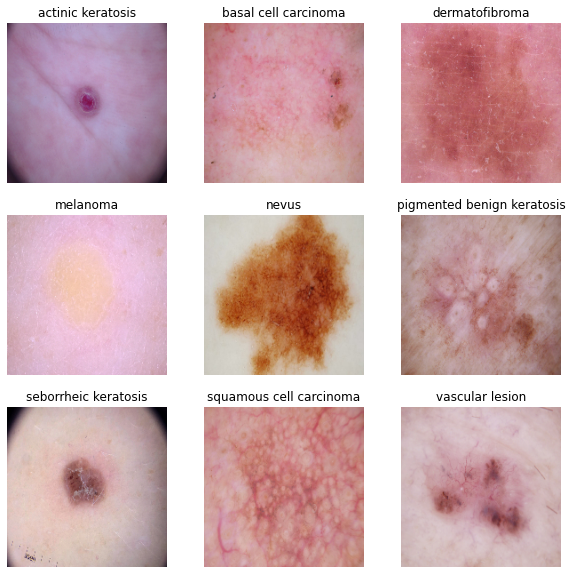

In [118]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [119]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### **1st Model Creation**


In [120]:
num_classes = 9

model1 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

Here, we are using three 'MaxPooling2D' layers to create a CNN model.

### **Model Compilation**

In [121]:
### Todo, choose an appropirate optimiser and loss function
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


Here, we have used 'SparseCategoricalCrossentropy' loss function.

In [122]:
# View the summary of all layers
model1.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_8 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 45, 45, 128)       73856     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 22, 22, 128)     

### Train the model

In [123]:
epochs = 20
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 751s 3s/step - loss: 2.5431 - accuracy: 0.2054 - val_loss: 1.7961 - val_accuracy: 0.2931
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 1.7078 - accuracy: 0.3985 - val_loss: 1.7210 - val_accuracy: 0.4094
Epoch 3/20
56/56 [==============================] - 1s 23ms/step - loss: 1.5004 - accuracy: 0.4878 - val_loss: 1.4204 - val_accuracy: 0.5056
Epoch 4/20
56/56 [==============================] - 1s 23ms/step - loss: 1.4352 - accuracy: 0.5038 - val_loss: 1.4333 - val_accuracy: 0.5101
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 1.2569 - accuracy: 0.5592 - val_loss: 1.3660 - val_accuracy: 0.5347
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.1688 - accuracy: 0.5810 - val_loss: 1.4839 - val_accuracy: 0.5302
Epoch 7/20
56/56 [==============================] - 1s 23ms/step - loss: 1.1528 - accuracy: 0.5834 - val_loss: 1.5268 - val_accuracy: 0.5011
Epoch 8/20
56

***Inferences***

*   Accuracy for train model is 90.75% and
*   accuracy for validation model is 52.35%
*   We can conclude that, our model is overfitting.





### Visualizing training results

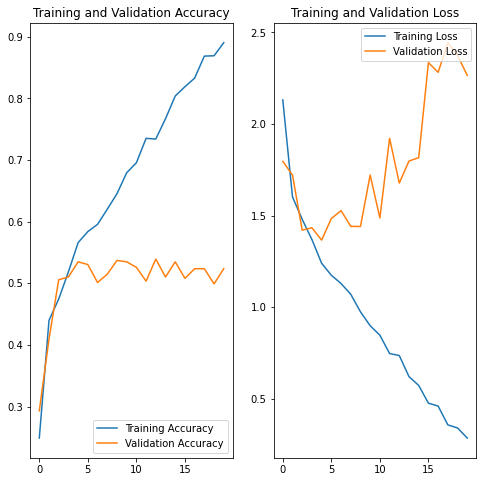

In [124]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Conclusion** : 
* After visualising the training result we can conclude that the model is **overfitting** as there is huge difference in training and validation accuracy.
* Training accuracy is much higher than validation accuracy.

**Thus**, we will create new model in order to deal with overfitting


In [125]:
# Data Augumentation.

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

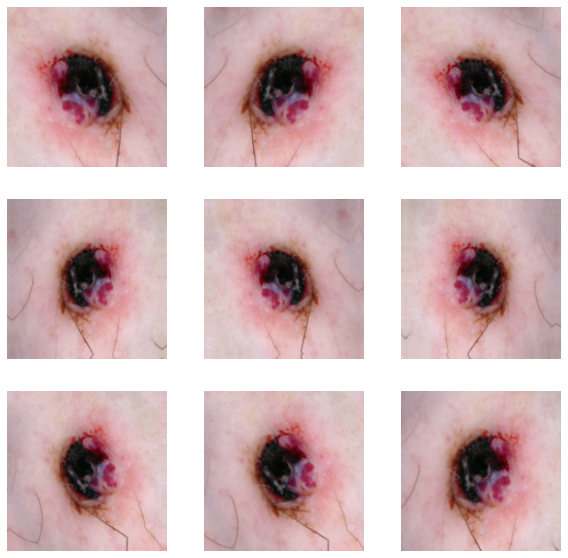

In [126]:
# visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model, compile and train the model


### **2nd Model Creation**

In [127]:
## Using Dropout layer as there is an evidence of overfitting in our previous model.

model2 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

Here, we are using 'Dropout' layers at each 'MaxPooling2D' layers to create a CNN model.

### Compiling the model

In [128]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Here, we have used 'SparseCategoricalCrossentropy' loss function.

### Training the model

In [129]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 27ms/step - loss: 4.8992 - accuracy: 0.1654 - val_loss: 2.0979 - val_accuracy: 0.2237
Epoch 2/20
56/56 [==============================] - 1s 25ms/step - loss: 2.0220 - accuracy: 0.2378 - val_loss: 1.9460 - val_accuracy: 0.2506
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.8634 - accuracy: 0.3168 - val_loss: 1.6979 - val_accuracy: 0.3915
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.6655 - accuracy: 0.3986 - val_loss: 1.6406 - val_accuracy: 0.4362
Epoch 5/20
56/56 [==============================] - 1s 25ms/step - loss: 1.5712 - accuracy: 0.4349 - val_loss: 1.5845 - val_accuracy: 0.4385
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4366 - accuracy: 0.4741 - val_loss: 1.5416 - val_accuracy: 0.4899
Epoch 7/20
56/56 [==============================] - 1s 25ms/step - loss: 1.4203 - accuracy: 0.4933 - val_loss: 1.4686 - val_accuracy: 0.4989
Epoch 8/20
56

***Inferences***

*   Accuracy for train model is 75.8% and
*   accuracy for validation model is 50.56%
*   We can conclude that, our model gives better result than previous   model.

### Visualizing the results

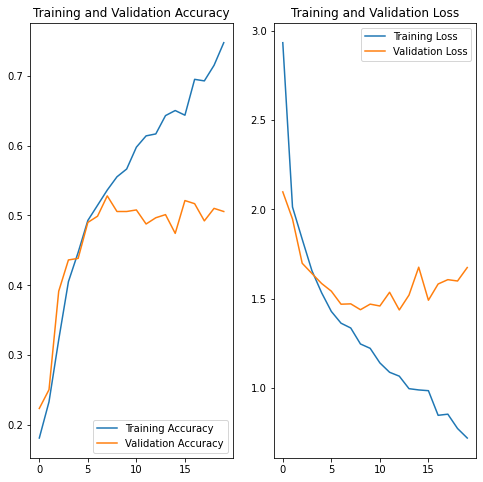

In [131]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#### **Conclusion** : 
* After visualising the training result we can conclude that our model(model2) gives better result than previous model(model1)

#### Distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

Text(0, 0.5, 'Number of Images')

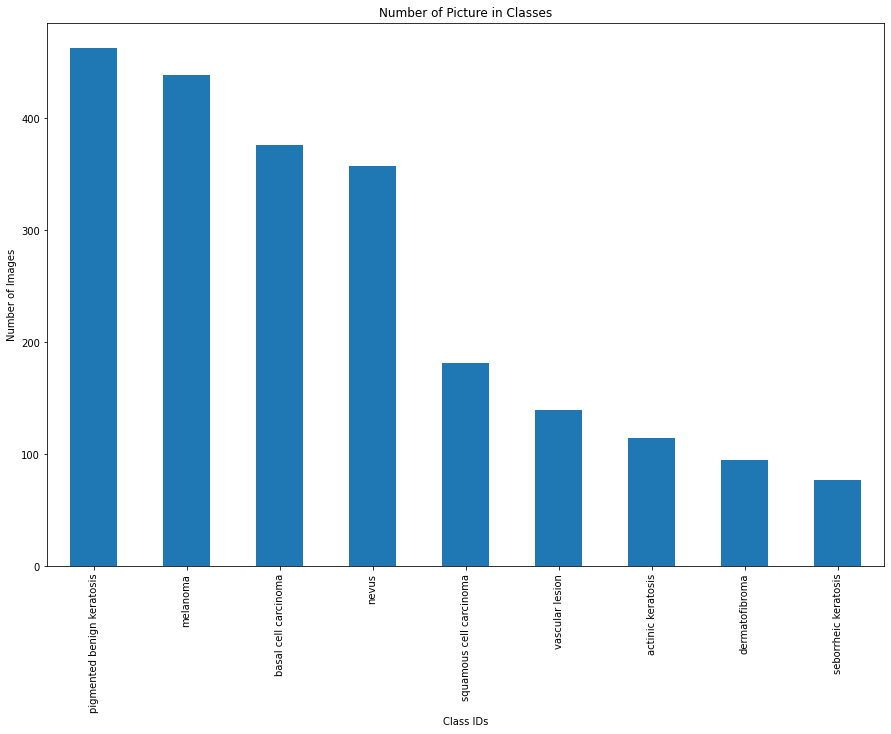

In [166]:
import glob
train_img_names = glob.glob('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/*/*.jpg')
train_img_names = pd.Series(train_img_names)
train_df = pd.DataFrame()

# Generating Filename field
train_df['File'] = train_img_names.map(lambda img_name: img_name.split("/")[-1])

# Generating ClassId field
train_df['Id'] = train_img_names.map(lambda img_name: img_name.split("/")[-2])

#Counting images belonging to each of 9 classes
class_id_dist = train_df['Id'].value_counts()

fig = plt.figure(figsize=(15,10))
class_id_dist.plot(kind='bar')
plt.title('Number of Picture in Classes')
plt.xlabel('Class IDs')
plt.ylabel('Number of Images')

#### - Which class has the least number of samples?
#### Ans- seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
#### Ans-  pigmented benign keratosis


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [133]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [134]:
path_to_training_dataset=str(data_dir_train)+"//"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train//actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F239F5BBA10>: 100%|██████████| 500/500 [00:17<00:00, 28.13 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F239F125A50>:   0%|          | 1/500 [00:00<01:12,  6.87 Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train//basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2300742990>: 100%|██████████| 500/500 [00:18<00:00, 27.31 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train//dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F239FB58850>: 100%|██████████| 500/500 [00:18<00:00, 27.26 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=722x542 at 0x7F239F691A50>:   0%|          | 1/500 [00:00<01:08,  7.30 Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train//melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F239E1205D0>: 100%|██████████| 500/500 [01:29<00:00,  5.58 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train//nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7F239F650B90>: 100%|██████████| 500/500 [01:19<00:00,  6.27 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F239FBB1E10>:   0%|          | 1/500 [00:00<01:22,  6.04 Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train//pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F239F6A50D0>: 100%|██████████| 500/500 [00:18<00:00, 26.68 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train//seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F239F8736D0>: 100%|██████████| 500/500 [00:40<00:00, 12.48 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F239F6A5510>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train//squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F239E2F0E90>: 100%|██████████| 500/500 [00:18<00:00, 27.53 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F239F678DD0>:   0%|          | 1/500 [00:00<01:08,  7.23 Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train//vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F239FBB1FD0>: 100%|██████████| 500/500 [00:18<00:00, 27.47 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [135]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [136]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025680.jpg_dccecd92-ac60-490d-8ac3-2acf4dd719bc.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030070.jpg_715f29e2-b8b8-43d3-b7ce-a00d81b4be1b.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033135.jpg_bac3054a-332c-4382-9b0b-c7ed0bd45fb4.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031955.jpg_7d9550ed-9e3a-4b2c-b94f-aba1d3e374af.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026713.jpg_0f9aecf9-2d5e-4dd3-b408-4b1863b2d

In [137]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [138]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [139]:
path_list_original = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list_original

['/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0026693.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0026349.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0026092.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0026456.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0026068.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0026336.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0026490.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vas

In [140]:
lesion_list_original = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_original

['Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',


In [141]:
dataframe_dict_original = dict(zip(path_list_original, lesion_list_original))

In [142]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [143]:
original_df['Label'].value_counts()

Train    2239
Name: Label, dtype: int64

In [144]:
new_df['Label'].value_counts()

Train                         2239
melanoma                       500
vascular lesion                500
basal cell carcinoma           500
actinic keratosis              500
nevus                          500
seborrheic keratosis           500
dermatofibroma                 500
pigmented benign keratosis     500
squamous cell carcinoma        500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [145]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

### **3rd Model** 

In [146]:
data_dir_train="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size = (img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [147]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [148]:
## your code goes here
num_classes = 9

model3 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
   layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [149]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


#### **Todo:**  Train your model

In [150]:
## Your code goes here, use 50 epochs.
epochs = 50
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs = epochs
)

Epoch 1/50
169/169 [==============================] - 38s 216ms/step - loss: 2.3811 - accuracy: 0.1982 - val_loss: 1.5298 - val_accuracy: 0.4046
Epoch 2/50
169/169 [==============================] - 37s 214ms/step - loss: 1.5278 - accuracy: 0.4485 - val_loss: 1.3694 - val_accuracy: 0.4863
Epoch 3/50
169/169 [==============================] - 37s 214ms/step - loss: 1.2580 - accuracy: 0.5313 - val_loss: 1.1583 - val_accuracy: 0.5679
Epoch 4/50
169/169 [==============================] - 37s 213ms/step - loss: 1.0389 - accuracy: 0.6224 - val_loss: 1.0872 - val_accuracy: 0.6073
Epoch 5/50
169/169 [==============================] - 37s 214ms/step - loss: 0.8646 - accuracy: 0.6961 - val_loss: 0.8942 - val_accuracy: 0.6644
Epoch 6/50
169/169 [==============================] - 37s 213ms/step - loss: 0.6971 - accuracy: 0.7569 - val_loss: 0.8445 - val_accuracy: 0.6808
Epoch 7/50
169/169 [==============================] - 37s 213ms/step - loss: 0.5691 - accuracy: 0.7911 - val_loss: 0.7543 - val_ac

***Inferences***

*   Accuracy for train model is 94.83% and
*   accuracy for validation model is 78.92%
*   We can conclude that, our model gives better result than previous   model.

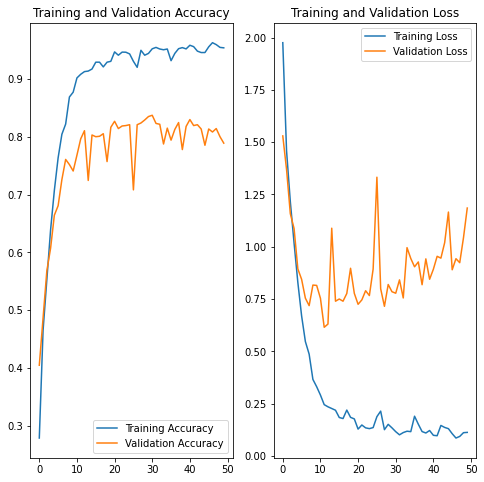

In [151]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Conclusion** : 
* After visualising the results we can conclude that we can achieve high training as well as validation accuracy.
* Also the difference between their accuracies is reduced.

**Thus** no sign of overfitting.
Clearly, class rebalance helped us to create optimised model.